<a href="https://colab.research.google.com/github/mqanaq/BA820-B1-Team13/blob/main/M3_Fair_Use_Data_Integrated_Analysis_%26_Synergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrated Analysis & Synergy For Fair Use Cases Data**

**Project Milestone 3**

**Team:** B1 Team 13

**Team Members:** Mohamad Gong, Danish Azmi, Suji Kim, Rita Feng

# Introduction

# Setting Up Environment

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Core
import os
import re
import math
import json
import time
import string
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# NLP / Text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Modeling / Anomaly detection
from sklearn.ensemble import IsolationForest

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Dimensionality reduction for viz
from sklearn.manifold import TSNE

# Data Importing, Inspection and Preparation

## Choosing the Working Analysis Table

In Milestone 2, the team used **both approaches**: some analyses worked entirely within a single table (most often `fair_use_findings`), while others attempted to merge `fair_use_cases` and `fair_use_findings` to enrich metadata. We explicitly tested whether the two tables could be integrated into a single “master” dataset. A straightforward join exposed structural mismatch in identifiers, producing only a **12% match rate**. Follow-up preprocessing improved linkage by normalizing formatting differences (e.g., standardizing “vs” to “v” and stripping punctuation), recovering **70.5% of records (177 cases)** in one improved approach. Other join strategies achieved results in the **low 30% range**, but still left a large portion unmatched. Even when match rates increase, the remaining unmatched share is large enough that (1) we risk losing too many cases if we require a strict join, and (2) we risk introducing false matches if we loosen the rules.

For Milestone 3, we prioritize a reproducible pipeline with minimal merge risk. As an integration choice, we therefore use **`fair_use_findings` as the single working analysis table** and treat `fair_use_cases` as optional metadata rather than a required dependency. This aligns with the milestone’s core modeling needs because our unsupervised methods depend most heavily on the narrative fields in `fair_use_findings`, while the structured fields in that table are sufficient for the planned comparisons.

**Key overlap and differences (without requiring a merge):**

* **Identifiers:** `fair_use_findings` includes `title` and `case_number`, which together serve the same reference role as the single `case` string in `fair_use_cases`. These fields are mainly used for labeling and lookup rather than as modeling features.
* **Year:** `year` is present in both tables and can be used directly without merging.
* **Court and venue information:** `fair_use_cases` includes `court` and `jurisdiction`, while `fair_use_findings` includes `court`. These are overlapping venue signals, and a single court field is sufficient for clustering and venue-aware comparisons.
* **Outcomes:** both tables include an `outcome` field describing the fair use result at a high level, supporting standardized labeling.
* **Text fields unique to `fair_use_findings`:** `key_facts`, `issue`, and `holding` provide the narrative summaries required for text-based unsupervised methods. In Milestone 2, the primary modeling text was often constructed from **`key_facts + issue`** to reduce decision-language leakage from holdings; this combined text averaged **about 145 words**, which is well suited to TF–IDF, topic modeling, and clustering workflows.

**Outcome labeling approach (used throughout M3):**

* Because `fair_use_findings` does not provide a boolean `fair_use_found`, we derive labels from `outcome` text and standardize into three groups: **fair use found**, **fair use not found**, and **indeterminate**.
* For venue comparisons, we compute outcome-related metrics using **determinate outcomes only**, avoiding mixed, preliminary, or remand-like resolutions.

Overall, while merging can add optional metadata, Milestone 2 showed that reliable integration requires record linkage plus validation and can still induce substantial case loss or matching risk. Since `fair_use_findings` already contains the critical unstructured fields used across all M3 modeling tracks, we proceed with a **one-table analysis** to maximize coverage, reduce merge-induced bias, and keep the pipeline reproducible.

## Data Importing

In [5]:
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [ ]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

## Preparing Data

### Outcome Flag Construction

The outcome column is converted into a simple label for analysis. The text is cleaned and then grouped into three outcomes: fair use found, fair use not found, and indeterminate (preliminary, mixed, remand, or unclear). A binary `fair_use_found` flag is created only for the final outcomes, and indeterminate cases are left out of binary rate calculations.

In [6]:
# Count outcome column from fair_use_findings and reset index
outcome_counts = fair_use_findings["outcome"].astype(str).str.lower().str.strip().value_counts().reset_index()
fair_use_findings["outcome"] = fair_use_findings["outcome"].astype(str).str.lower().str.strip()
outcome_counts.columns = ["outcome", "count"]

# Display the counts
print(outcome_counts)

                                              outcome  count
0                                  fair use not found    100
1                                      fair use found     98
2         preliminary ruling, mixed result, or remand     28
3             preliminary finding; fair use not found      4
4                                        mixed result      3
5              preliminary ruling, fair use not found      3
6              fair use not found, preliminary ruling      3
7              preliminary ruling; fair use not found      2
8              fair use not found; preliminary ruling      2
9                          preliminary ruling, remand      1
10                                fair use not found.      1
11                                    fair use found.      1
12  preliminary ruling, fair use not found, mixed ...      1
13                 preliminary ruling, fair use found      1
14  fair use found; second circuit affirmed on app...      1
15                      

Based on the grouped outcome counts, outcomes fall into three clear categories. Entries labeled “Fair use found” (including minor punctuation or appeal notes) are treated as fair use found, and entries labeled “Fair use not found” (including punctuation variants) are treated as fair use not found. All remaining outcomes, such as preliminary rulings, mixed results, remands, and irregular text entries, are treated as indeterminate. A binary fair_use_found flag is then defined only for the final outcomes, while indeterminate cases are excluded from binary rate calculations.

In [7]:
outcome_map = {
    # FINAL: fair use found
    "fair use found": "FAIR_USE_FOUND",
    "fair use found.": "FAIR_USE_FOUND",
    "fair use found; second circuit affirmed on appeal.": "FAIR_USE_FOUND",

    # FINAL: fair use not found
    "fair use not found": "FAIR_USE_NOT_FOUND",
    "fair use not found.": "FAIR_USE_NOT_FOUND",

    # INDETERMINATE
    "preliminary ruling, mixed result, or remand": "INDETERMINATE",
    "preliminary finding; fair use not found": "INDETERMINATE",
    "mixed result": "INDETERMINATE",
    "preliminary ruling, fair use not found": "INDETERMINATE",
    "fair use not found, preliminary ruling": "INDETERMINATE",
    "preliminary ruling; fair use not found": "INDETERMINATE",
    "fair use not found; preliminary ruling": "INDETERMINATE",
    "preliminary ruling, remand": "INDETERMINATE",
    "preliminary ruling, fair use not found, mixed result": "INDETERMINATE",
    "preliminary ruling, fair use found": "INDETERMINATE",
    "fair use found; mixed result": "INDETERMINATE",
    "plaintiff patrick cariou published yes rasta, a book of portraits and landscape photographs taken in jamaica. defendant richard prince was an appropriation artist who altered and incorporated several of plaintiff’s photographs into a series of paintings and collages called canal zone that was exhibited at a gallery and in the gallery’s exhibition catalog. plaintiff filed an infringement claim, and the district court ruled in his favor, stating that to qualify as fair use, a secondary work must “comment on, relate to the historical context of, or critically refer back to the original works.” defendant appealed.": "INDETERMINATE",
}

In [ ]:
# Replace outcome column values with the mapping in outcome_map
fair_use_findings["outcome"] = fair_use_findings["outcome"].replace(outcome_map)
fair_use_findings["outcome"].value_counts().reset_index()

,outcome,count
0,FAIR_USE_NOT_FOUND,101
1,FAIR_USE_FOUND,100
2,INDETERMINATE,50


### Column Cleaning Steps

The `year` column is converted to a numeric integer format to ensure it can be used reliably in grouping, filtering, and any downstream modeling steps. Any non-numeric or missing values are handled safely during conversion.

In [8]:
# Turn the year column to integer
fair_use_findings["year"] = pd.to_numeric(fair_use_findings["year"], errors="coerce").astype("Int64")

In [ ]:
fair_use_findings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         250 non-null    Int64 
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: Int64(1), object(8)
memory usage: 18.0+ KB


In [9]:
fair_use_findings.head()

,title,case_number,year,court,key_facts,issue,holding,tags,outcome
0,De Fontbrune v. Wofsy,39 F.4th 1214 (9th Cir. 2022),2022,United States Court of Appeals for the Ninth C...,Plaintiffs own the rights to a catalogue compr...,Whether reproduction of photographs documentin...,"The panel held that the first factor, the purp...",Education/Scholarship/Research; Photograph,fair use not found
1,Sedlik v. Von Drachenberg,"No. CV 21-1102, 2022 WL 2784818 (C.D. Cal. May...",2022,United States District Court for the Southern ...,Plaintiff Jeffrey Sedlik is a photographer who...,Whether use of a photograph as the reference i...,"Considering the first fair use factor, the pur...",Painting/Drawing/Graphic; Photograph,preliminary finding; fair use not found
2,"Sketchworks Indus. Strength Comedy, Inc. v. Ja...","No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 8...",2022,United States District Court for the Southern ...,Plaintiff Sketchworks Industrial Strength Come...,"Whether the use of protected elements, includi...","The court found that the first factor, the pur...",Film/Audiovisual; Music; Parody/Satire; Review...,fair use found
3,Am. Soc'y for Testing & Materials v. Public.Re...,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",2022,United States District Court for the District ...,"Defendant Public.Resource.Org, Inc., a non-pro...",Whether it is fair use to make available onlin...,"As directed by the court of appeals, the distr...",Education/Scholarship/Research; Textual Work; ...,mixed result
4,Yang v. Mic Network Inc.,"Nos. 20-4097-cv(L), 20-4201-cv (XAP), 2022 U.S...",2022,United States Court of Appeals for the Second ...,Plaintiff Stephen Yang (“Yang”) licensed a pho...,"Whether using a screenshot from an article, in...","On appeal, the court decided that the first fa...",News Reporting; Photography,fair use found


# Integration Strategy and Synergy Effort

**Plan overview:**

1) **Build a shared topic-model backbone (case types).**  
   - Create a single text-based representation of each case using `key_facts + issue`.  
   - Fit a topic model and derive **case types** (topic mixtures / clusters).  
   - Rationale: this becomes a reusable foundation for questions that need comparability and semantic structure.

2) **Run Q4 first using all cases (full coverage).**  
   - Use the full `fair_use_findings` table (≈250 cases).  
   - Rationale: Q4 is boundary-focused; keeping all cases maximizes the chance of capturing true edge cases rather than filtering them out.

3) **Execute Q1–Q3 with minimal changes to proven M2 logic.**  
   - **Q1 (precedent finder):** reuse the topic-model backbone as the semantic engine for text-based similarity and retrieval.  
   - **Q2 (venue fairness):** keep the same approach; use case types to control for case mix and compare actual vs expected outcomes by venue.  
   - **Q3 (scenario bundles):** keep the same approach and treat it as largely isolated; focus on tag/category co-occurrence patterns.

The main synergy is that the **topic-model case types** created once are reused for **Q1 retrieval** and **Q2 case-mix control**, while **Q4** benefits most from full-case coverage. Q3 remains primarily independent.

# Topic Modeling

The text input for topic modeling is constructed by combining `key_facts` and `issue`. These fields describe the dispute context and legal question, and they are used to define “case types” without leaking decision language from holding. Basic cleaning (lowercasing and whitespace normalization) is applied to reduce superficial variation before vectorization.

In [10]:
# Combine key facts + issue into one text field for topic modeling
fair_use_findings["text"] = (
    fair_use_findings["key_facts"].fillna("").astype(str) + " " +
    fair_use_findings["issue"].fillna("").astype(str)
)

# Basic cleaning: lowercase, collapse whitespace, trim
fair_use_findings["text"] = (
    fair_use_findings["text"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

Topic modeling is used to extract dispute themes from the combined `key_facts + issue` text. The primary approach uses **NMF on a TF–IDF–weighted document–term matrix**, which downweights common boilerplate terms and typically produces clearer and more distinct topic vocabularies, especially for short case summaries. In M3, we fit NMF with **K = 10** topics and use the resulting **topic-word summaries** and **per-case topic mixtures** as a stable, interpretable “case-type” representation for later steps in the notebook.

## Non-negative Matrix Factorization (NMF)

TF-IDF is used to downweight very common legal terms and emphasize terms that distinguish cases by fact patterns. NMF is then fit to the TF-IDF matrix to extract non-negative topic components, producing interpretable themes that can be treated as text-derived “case types.” These topic mixtures provide a compact numeric representation of each case summary for later analysis.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Define the number of topics (K) to investigate for NMF.
# We use K=10 based on the selected configuration.
K_try = [10]

# Initialize TF-IDF vectorizer for text feature extraction.
tfidf_vec = TfidfVectorizer(
    stop_words="english",
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)

# Transform text data into TF-IDF features.
X_tfidf = tfidf_vec.fit_transform(fair_use_findings["text"])
# Store the vocabulary terms for interpretation.
terms_tfidf = tfidf_vec.get_feature_names_out()

# Prepare to store NMF results for each K value.
nmf_results = {}

# Loop through each specified number of topics (K) to run NMF.
for K in K_try:
    # Set up the NMF model for the current K.
    nmf = NMF(n_components=K, random_state=42, init="nndsvda", max_iter=400)
    # Apply NMF to extract topic distributions per document.
    nmf_doc_topic = nmf.fit_transform(X_tfidf)

    # Record the model's output and key metrics for the current K.
    nmf_results[K] = {
        "model": nmf,
        "doc_topic": nmf_doc_topic,                 # (n_cases, K) topic weights per case
        "dominant_topic": nmf_doc_topic.argmax(1),  # length n_cases
        "reconstruction_err": nmf.reconstruction_err_,
        "terms": terms_tfidf
    }

    # Assign the dominant topic for the current K to the DataFrame.
    fair_use_findings[f"nmf_topic_k{K}"] = nmf_results[K]["dominant_topic"]

    # Report the reconstruction error for the NMF model at current K.
    print(f"NMF K={K} | recon_err={nmf_results[K]['reconstruction_err']:.4f}")

NMF K=10 | recon_err=14.7173


In [ ]:
# Define the number of top words to display for each topic.
top_n = 10

# Iterate through each NMF model trained with different numbers of topics (K).
for K in K_try:
    # Retrieve the NMF model and the corresponding vocabulary terms for the current K.
    nmf = nmf_results[K]["model"]
    terms = nmf_results[K]["terms"]

    # Print a header for the current K to delineate the output.
    print(f"\nTop words per topic (NMF, K={K})")
    # For each topic generated by the NMF model, extract and display its most representative words.
    for topic_id, topic_weights in enumerate(nmf.components_):
        # Get the indices of the top 'top_n' words based on their weights in the current topic.
        top_idx = topic_weights.argsort()[::-1][:top_n]
        # Print the topic ID and the comma-separated list of its top words.
        print(f"Topic {topic_id}: " + ", ".join(terms[top_idx]))


Top words per topic (NMF, K=10)
Topic 0: defendants, plaintiff, advertisement, parody, campaign, sculpture, hustler, defendants unauthorized, video, unauthorized
Topic 1: photograph, post, article, instagram, copyright, use photograph, new, posted, blog, photographer
Topic 2: defendant, plaintiff, book, court, published, ruling, novel, district, appealed district, court ruling
Topic 3: news, footage, lans, angeles, los, los angeles, service, video, news service, defendant
Topic 4: plaintiffs, works, university, factor, factors, court, students, district, district court, publishers
Topic 5: photographs, images, photos, gossip, celebrity, website, defendant, use photographs, celebrity gossip, plaintiff photographs
Topic 6: film, documentary, films, clips, star, scenes, rights, jewish, film clips, defendant
Topic 7: game, video, code, software, computer, program, sony, games, video game, fox
Topic 8: series, television series, television, character, superman, book, superhero, characters,

Across the values evaluated in Milestone 2, the dominant-topic counts showed a consistent pattern: smaller K values produced a few very broad buckets that mixed multiple dispute themes, while larger K values progressively split those buckets into narrower themes. This comparison is useful for validating whether the model is producing usable “case types,” since overly broad topics reduce interpretability, while very small topics can become unstable or too specific to interpret reliably.

Based on those Milestone 2 checks, **K = 10** was selected as a practical middle ground. At K = 10, topics remain distinct enough to label and interpret, and the topic-size distribution avoids both the heavy collapse seen at lower K and the proliferation of tiny niche topics that emerges at higher K. Combined with the reconstruction-error knee-point diagnostics conducted in M2, this supports using **K = 10** as a stable configuration for downstream case-type analysis.

### Viewing The Results

In [ ]:
K = 10
W = nmf_results[K]["doc_topic"]  # shape: (n_cases, K)

topic_cols = [f"topic_{i}" for i in range(K)]

nmf_topic_weights_k10 = pd.DataFrame(W, columns=topic_cols)
nmf_topic_weights_k10.insert(0, "case_number", fair_use_findings["case_number"].values)

# Useful summary columns (kept inside this table, not added back to fair_use_findings)
nmf_topic_weights_k10["dominant_topic"] = W.argmax(axis=1)
nmf_topic_weights_k10["dominant_weight"] = W.max(axis=1)

nmf_topic_weights_k10.head(10)

,case_number,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,dominant_topic,dominant_weight
0,39 F.4th 1214 (9th Cir. 2022),0.041529,0.000000,0.000000,0.000000,0.225198,0.178476,0.000000,0.000000,0.028705,0.043319,4,0.225198
1,"No. CV 21-1102, 2022 WL 2784818 (C.D. Cal. May...",0.021433,0.135854,0.000000,0.000000,0.000000,0.000851,0.000000,0.065274,0.000000,0.013951,1,0.135854
2,"No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 8...",0.062300,0.000000,0.000000,0.000000,0.000000,0.000000,0.167525,0.000000,0.025972,0.167756,9,0.167756
3,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",0.000000,0.012402,0.023487,0.000000,0.277498,0.026679,0.000000,0.039535,0.011493,0.011300,4,0.277498
4,"Nos. 20-4097-cv(L), 20-4201-cv (XAP), 2022 U.S...",0.000000,0.435800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014149,1,0.435800
5,"Civ. Action No H-21-2612, 2022 U.S. Dist. LEXI...",0.000000,0.009973,0.000000,0.004021,0.041133,0.004524,0.021205,0.005756,0.270322,0.000000,8,0.270322
6,"19 Civ. 9617 (KPF), 2022 U.S. Dist. LEXIS 5023...",0.000000,0.299204,0.000000,0.000000,0.000000,0.118378,0.000000,0.000000,0.000000,0.000000,1,0.299204
7,28 F.4th 314 (1st Cir. 2022),0.000000,0.183423,0.020887,0.000000,0.048423,0.000000,0.000000,0.051223,0.000000,0.007696,1,0.183423
8,27 F.4th 313 (5th Cir. 2022),0.000000,0.059604,0.085241,0.000000,0.000000,0.009576,0.000022,0.017786,0.016768,0.022853,2,0.085241
9,"No. 19 CIV. 9769 (AT), 2021 WL 4443259 (S.D.N....",0.000000,0.422517,0.000000,0.011960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.422517


In [ ]:
terms = nmf_results[10]["terms"]
H = nmf_results[10]["model"].components_  # shape: (K, n_terms)

top_n = 20
topic_labels_k10 = {}
for t in range(K):
    top_idx = np.argsort(H[t])[-top_n:][::-1]
    topic_labels_k10[t] = ", ".join(terms[top_idx])

pd.DataFrame({
    "topic": list(topic_labels_k10.keys()),
    "top_words": list(topic_labels_k10.values())
})

,topic,top_words
0,0,"defendants, plaintiff, advertisement, parody, ..."
1,1,"photograph, post, article, instagram, copyrigh..."
2,2,"defendant, plaintiff, book, court, published, ..."
3,3,"news, footage, lans, angeles, los, los angeles..."
4,4,"plaintiffs, works, university, factor, factors..."
5,5,"photographs, images, photos, gossip, celebrity..."
6,6,"film, documentary, films, clips, star, scenes,..."
7,7,"game, video, code, software, computer, program..."
8,8,"series, television series, television, charact..."
9,9,"song, music, musical, lyrics, defendants, albu..."


# Q4: Red-flag Cases and Boundary Conditions

The purpose of Q4 is to find "red-flag" cases, which are legal outliers that don't follow the usual rules. Q1 and Q2 look for examples and average venue behaviors, while Q4 looks for boundary conditions, which are cases with unusual textual complexity, unusual tag combinations, or unique semantic themes.

Finding these strange cases is very important for business triage. "Red-flag" cases are high-risk disputes that probably need to be looked at by a senior-level person or require specialized legal help because they could lead to unexpected or expensive litigation outcomes.

In Milestone 2, Q4 analysis was limited to the subset of cases successfully merged between the two primary tables. In **Milestone 3**, we switch to a **"Full Coverage"** method that uses the whole `fair_use_findings` dataset (~250 cases). This ensures that rare "edge cases" aren't lost due to merging limits, increasing our detection sensitivity.

To capture both the structure and content of these disputes, we utilize a 13-dimensional feature set:
* **Structural Metadata (3):** `holding_word_count` (complexity), `tag_count` (multidimensionality), and `year` (temporal drift).

* **Semantic Topics (10):** The shared topic weights derived from the team's NMF backbone, representing the factual themes of the cases.

In [ ]:
fair_use_findings['holding_word_count'] = fair_use_findings['holding'].fillna("").apply(lambda x: len(str(x).split()))

# number of tags
fair_use_findings['tag_count'] = fair_use_findings['tags'].fillna("").apply(lambda x: len(re.split(r'[;,]', str(x))) if x else 0)

median_year = fair_use_findings['year'].median()
fair_use_findings['year_filled'] = fair_use_findings['year'].fillna(median_year)

# Scaling for Isolation Forest
features = fair_use_findings[['holding_word_count', 'tag_count', 'year_filled']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42) # 5%
fair_use_findings['is_outlier'] = iso_forest.fit_predict(features_scaled)

red_flags = fair_use_findings[fair_use_findings['is_outlier'] == -1]
print(f"Total Red-flag cases found: {len(red_flags)} out of {len(fair_use_findings)}")

Total Red-flag cases found: 13 out of 251


In [ ]:
# Combining the NMF topic modeling results with outlier detection in Q4
synergy_crosstab = pd.crosstab(
    fair_use_findings['nmf_topic_k10'],
    fair_use_findings['is_outlier'],
    margins=True,
    margins_name="Total"
)

# 1: Normal, -1: Red-flag
synergy_crosstab.rename(columns={1: 'Normal_Cases', -1: 'Red_Flag_Cases'}, inplace=True)

# Red-flag Occurrence Rate
synergy_crosstab['Red_Flag_Rate(%)'] = (synergy_crosstab['Red_Flag_Cases'] / synergy_crosstab['Total'] * 100).round(2)

print("\nRed-flag Concentration by NMF Topic (Case Type)")
display(synergy_crosstab.sort_values(by='Red_Flag_Rate(%)', ascending=False))


Red-flag Concentration by NMF Topic (Case Type)


is_outlier,Red_Flag_Cases,Normal_Cases,Total,Red_Flag_Rate(%)
nmf_topic_k10,,,,
9,2,22,24,8.33
4,2,23,25,8.00
7,2,24,26,7.69
2,4,52,56,7.14
6,1,15,16,6.25
Total,13,238,251,5.18
0,1,19,20,5.00
5,1,25,26,3.85
1,0,31,31,0.00


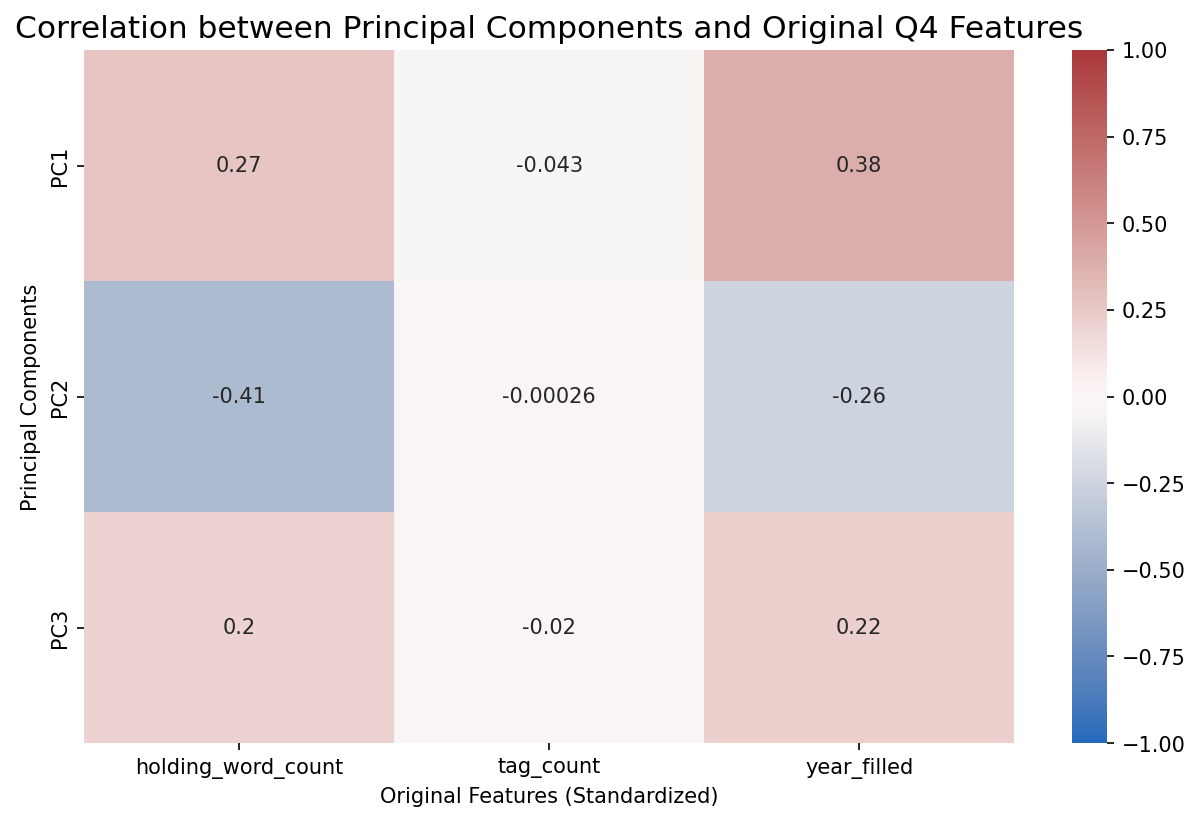

In [ ]:
# Convert X_tfidf to a dense array and apply 3D PCA
pca_3d = PCA(n_components=3, random_state=42)
pca_results_3d = pca_3d.fit_transform(X_tfidf.toarray())

pc_columns = ['PC1', 'PC2', 'PC3']
transformed_data = pd.DataFrame(pca_results_3d, columns=pc_columns)

original_features_df = pd.DataFrame(features_scaled, columns=['holding_word_count', 'tag_count', 'year_filled'])
combined_df = pd.concat([transformed_data, original_features_df], axis=1)

correlation_matrix = combined_df.corr().loc[pc_columns, ['holding_word_count', 'tag_count', 'year_filled']]

plt.figure(figsize=(10, 6), dpi=150)
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', vmin=-1, vmax=1, center=0)

plt.title('Correlation between Principal Components and Original Q4 Features', fontsize=15)
plt.ylabel('Principal Components')
plt.xlabel('Original Features (Standardized)')
plt.show()

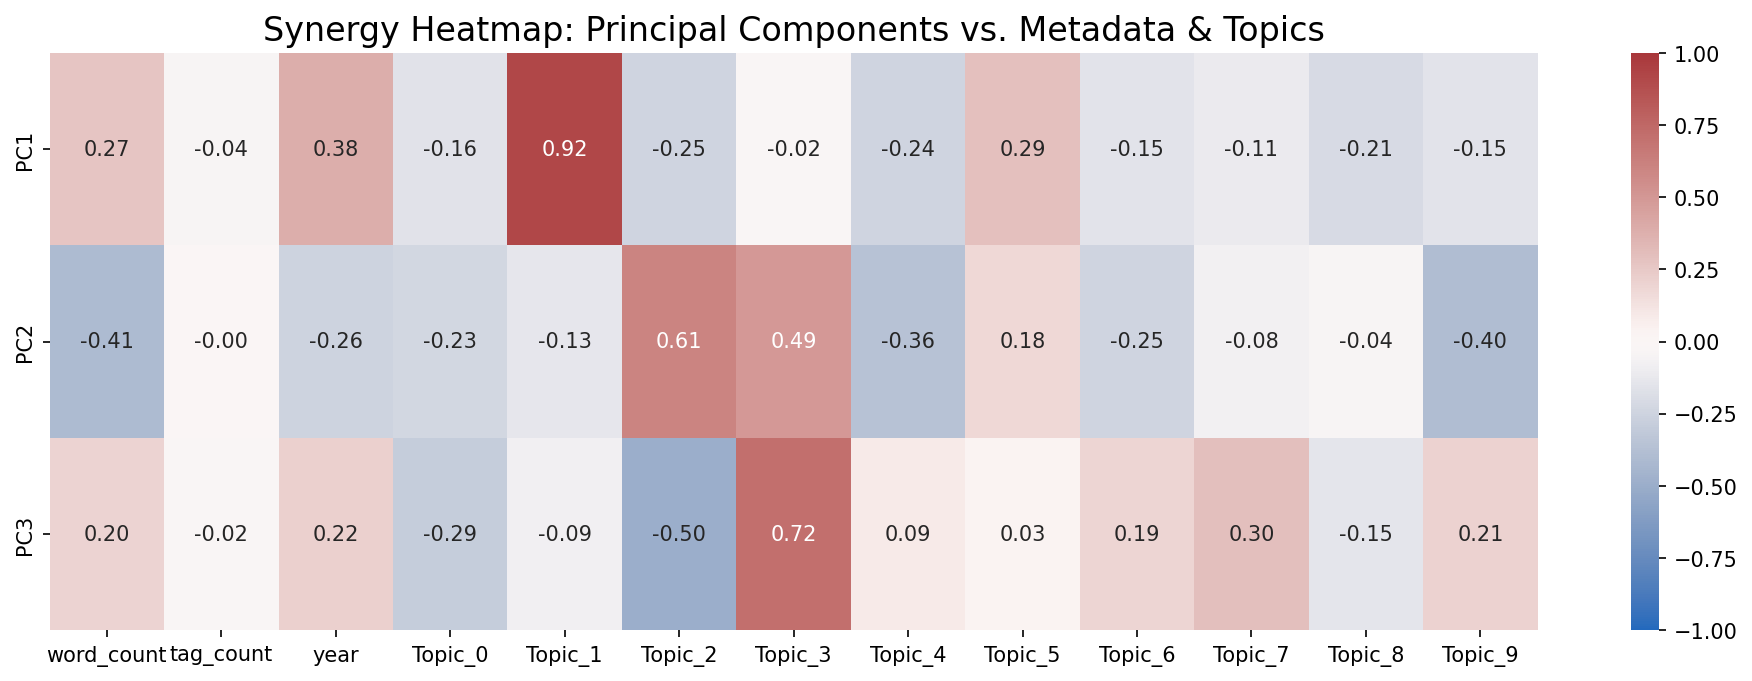

In [ ]:
# Get 10 NMF topic weights
topic_weights_df = pd.DataFrame(
    nmf_results[10]['doc_topic'],
    columns=[f'Topic_{i}' for i in range(10)]
)

# Merge with existing 3 numerical features
metadata_features_df = pd.DataFrame(
    features_scaled,
    columns=['word_count', 'tag_count', 'year']
)

all_original_features = pd.concat([metadata_features_df, topic_weights_df], axis=1)

transformed_data = pd.DataFrame(pca_results_3d, columns=['PC1', 'PC2', 'PC3'])
combined_for_corr = pd.concat([transformed_data, all_original_features], axis=1)

correlation_matrix = combined_for_corr.corr().loc[['PC1', 'PC2', 'PC3'], all_original_features.columns]

plt.figure(figsize=(16, 5), dpi=150)
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', vmin=-1, vmax=1, center=0, fmt=".2f")

plt.title('Synergy Heatmap: Principal Components vs. Metadata & Topics', fontsize=16)
plt.show()

3D Semantic Landscape Integrated Visualization (PCA)

In [ ]:
fair_use_findings['pc1'] = pca_results_3d[:, 0]
fair_use_findings['pc2'] = pca_results_3d[:, 1]
fair_use_findings['pc3'] = pca_results_3d[:, 2]

fig = px.scatter_3d(
    fair_use_findings,
    x='pc1', y='pc2', z='pc3',
    color='is_outlier',
    color_continuous_scale=['red', 'gray'],
    hover_name='title',
    hover_data=['year_filled', 'holding_word_count', 'nmf_topic_k10'],
    title='3D Semantic Landscape of Fair Use Cases (M3 Synergy Integration)',
    opacity=0.8
)

fig.update_layout(height=700, width=900)
fig.show()

# Q1: Fact-Based Precedent Finder

The goal of Q1 is to support precedent lookup by retrieving past fair-use cases that are most similar to a new dispute description, based on factual context and issue framing rather than superficial metadata. The deliverable is a ranked list of precedent cases with short explanation cues for why each match is relevant.

In Milestone 2, Q1 relied more heavily on categories/tags and other structured fields as a coarse proxy for comparability, and different clustering/topic settings were experimented with. In Milestone 3, Q1 shifts to a text-driven approach: we reuse the topic-model backbone as the semantic engine for similarity and use clustering as a routing layer to improve comparability.


For Q1 retrieval, each case is represented by its **topic-weight values** from the final topic model configuration (**K = 10 topics**, carried forward from M2 experimentation). The feature matrix contains only these topic-weight columns, keeping the representation tightly tied to dispute themes learned from `key_facts + issue`.

We standardize the topic-weight features so no single topic dimension dominates distance calculations, then apply K-means using the final cluster configuration (**k = 10 case types**, consistent with the final M2 setup). These case types serve as a routing layer for retrieval: similarity search can be prioritized within the most comparable case type rather than over the entire corpus.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Retrieve the document-topic matrix from the NMF results for K=10
W = nmf_results[10]["doc_topic"]

# Apply standard scaling to the topic weights matrix
X_cluster = StandardScaler().fit_transform(W)

# Print the shape of the resulting feature matrix
print("X_cluster shape:", X_cluster.shape)

# Create a list of column names for the topics
cluster_cols = [f"topic_w{i}" for i in range(10)]

# Construct a DataFrame with the topic weights for inspection
cluster_df = pd.DataFrame(W, columns=cluster_cols)

# Display the first 5 rows of the DataFrame
cluster_df.head()

X_cluster shape: (251, 10)


,topic_w0,topic_w1,topic_w2,topic_w3,topic_w4,topic_w5,topic_w6,topic_w7,topic_w8,topic_w9
0,0.041529,0.000000,0.000000,0.0,0.225198,0.178476,0.000000,0.000000,0.028705,0.043319
1,0.021433,0.135854,0.000000,0.0,0.000000,0.000851,0.000000,0.065274,0.000000,0.013951
2,0.062300,0.000000,0.000000,0.0,0.000000,0.000000,0.167525,0.000000,0.025972,0.167756
3,0.000000,0.012402,0.023487,0.0,0.277498,0.026679,0.000000,0.039535,0.011493,0.011300
4,0.000000,0.435800,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.014149


In [ ]:
from sklearn.cluster import KMeans

# Final clustering configuration (based on M2 experimentation)
k_final = 10

# Fit K-Means on standardized topic-weight features only
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=50)
fair_use_findings["case_type_cluster"] = kmeans.fit_predict(X_cluster)

# Check cluster sizes
print("Cluster sizes (k=10):")
print(fair_use_findings["case_type_cluster"].value_counts().sort_index())

Cluster sizes (k=10):
case_type_cluster
0    12
1    23
2    68
3    63
4    21
5     5
6    21
7    11
8     7
9    20
Name: count, dtype: int64


This step adds a `case_type_cluster` label to every case. For Q1, the cluster label is not the final answer by itself—it is a **routing layer** that makes retrieval more comparable and less noisy.

With this final configuration, Q1 precedent retrieval uses:
1) the topic-weight representation (semantic structure), and
2) the case-type cluster label (routing for comparability),
to retrieve and explain the most relevant precedent cases for a new dispute description.


We present Q1 results in two parts:

1) **Case-type interpretability:** summarize each case type using its strongest topics and a few example case titles.
2) **Precedent retrieval output:** for a query dispute description, return a ranked “precedent list” with:
   - title, court, year, outcome label
   - similarity score
   - short explanation cues (shared high-weight terms)

These two views make the retrieval system both *usable* and *auditable*.


In [ ]:
terms = nmf_results[10]["terms"]
H = nmf_results[10]["model"].components_

def top_words_for_topic(t, top_n=12):
    idx = np.argsort(H[t])[-top_n:][::-1]
    return [terms[i] for i in idx]

topic_top_words = {t: top_words_for_topic(t, 12) for t in range(10)}

# Summarize each case type cluster by its strongest average topics
cluster_topic_means = pd.DataFrame(W).groupby(fair_use_findings["case_type_cluster"]).mean()
cluster_top_topics = cluster_topic_means.apply(lambda row: list(np.argsort(row.values)[::-1][:3]), axis=1)

summary_rows = []
for c in sorted(fair_use_findings["case_type_cluster"].unique()):
    top_topics = cluster_top_topics.loc[c]
    ex = fair_use_findings[fair_use_findings["case_type_cluster"] == c].head(3)["title"].tolist()
    summary_rows.append({
        "case_type_cluster": c,
        "top_topics": top_topics,
        "topic_keywords": " | ".join([", ".join(topic_top_words[t][:8]) for t in top_topics]),
        "example_titles": "; ".join(ex)
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values("case_type_cluster")
cluster_summary

,case_type_cluster,top_topics,topic_keywords,example_titles
0,0,"[7, 0, 2]","game, video, code, software, computer, program...","Google LLC v. Oracle Am., Inc.; Rimini St. v. ..."
1,1,"[1, 5, 6]","photograph, post, article, instagram, copyrigh...",Sedlik v. Von Drachenberg; Yang v. Mic Network...
2,2,"[2, 8, 1]","defendant, plaintiff, book, court, published, ...",Bell v. Eagle Mt. Saginaw Indep. Sch. Distr.; ...
3,3,"[0, 7, 4]","defendants, plaintiff, advertisement, parody, ...","Easter Unlimited, Inc. v. Rozier; Nat'l Acad. ..."
4,4,"[5, 1, 2]","photographs, images, photos, gossip, celebrity...",McGucken v. Pub Ocean Ltd.; Noland v. Janssen;...
5,5,"[3, 2, 7]","news, footage, lans, angeles, los, los angeles...","L.A. News Serv. v. CBS Broad., Inc.,; L.A. New..."
6,6,"[4, 2, 7]","plaintiffs, works, university, factor, factors...",De Fontbrune v. Wofsy; Am. Soc'y for Testing &...
7,7,"[6, 4, 2]","film, documentary, films, clips, star, scenes,...","Bain v. Film Indep., Inc.; Paramount Pictures ..."
8,8,"[8, 2, 4]","series, television series, television, charact...",Viacom Int’l v. Pixi Universal; Adjmi v. DLT E...
9,9,"[9, 6, 0]","song, music, musical, lyrics, defendants, albu...","Sketchworks Indus. Strength Comedy, Inc. v. Ja..."


In [ ]:
def top_overlap_terms(q_vec, d_vec, feature_names, top_n=8):
    contrib = q_vec.multiply(d_vec)
    if contrib.nnz == 0:
        return []
    idx = np.argsort(contrib.data)[::-1][:top_n]
    term_ids = contrib.indices[idx]
    return [feature_names[i] for i in term_ids]

def retrieve_precedents(query_text, top_n=8, restrict_to_same_case_type=True):
    q = str(query_text).lower().strip()
    q_vec = tfidf_vec.transform([q])
    sims = cosine_similarity(q_vec, X_tfidf).ravel()

    if restrict_to_same_case_type:
        # Assign query to most similar case type using topic centroids
        qW = nmf_results[10]["model"].transform(q_vec)
        centroids = pd.DataFrame(W).groupby(fair_use_findings["case_type_cluster"]).mean().values
        q_type = int(np.argmax(cosine_similarity(qW, centroids).ravel()))

        mask = (fair_use_findings["case_type_cluster"] == q_type).to_numpy()
        sims = np.where(mask, sims, -1)

    top_idx = np.argsort(sims)[::-1][:top_n]

    rows = []
    for i in top_idx:
        expl = top_overlap_terms(q_vec, X_tfidf[i], terms_tfidf, top_n=8)
        rows.append({
            "title": fair_use_findings.iloc[i]["title"],
            "case_number": fair_use_findings.iloc[i]["case_number"],
            "year": fair_use_findings.iloc[i]["year"],
            "court": fair_use_findings.iloc[i]["court"],
            "outcome": fair_use_findings.iloc[i]["outcome"],
            "case_type_cluster": fair_use_findings.iloc[i]["case_type_cluster"],
            "similarity": float(sims[i]),
            "explanation_terms": ", ".join(expl)
        })

    return pd.DataFrame(rows)

# Demo: use one existing case as the query (acts like a "new dispute" proxy)
demo_query = fair_use_findings.loc[0, "text"]
retrieve_precedents(demo_query, top_n=10, restrict_to_same_case_type=True)

,title,case_number,year,court,outcome,case_type_cluster,similarity,explanation_terms
0,De Fontbrune v. Wofsy,39 F.4th 1214 (9th Cir. 2022),2022,United States Court of Appeals for the Ninth C...,FAIR_USE_NOT_FOUND,6,1.000000,"catalogue, plaintiffs, photographs, judgment, ..."
1,"Meeropol v. Nizer,",560 F.2d 1061 (2d Cir. 1977),1977,United States Court of Appeals for the Second ...,INDETERMINATE,6,0.187706,"plaintiffs, judgment, plaintiffs sought, damag..."
2,Am. Soc'y for Testing & Materials v. Public.Re...,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",2022,United States District Court for the District ...,INDETERMINATE,6,0.147122,"plaintiffs, judgment, reference, copies, obtai..."
3,"Cambridge Univ. Press v. Patton,",769 F.3d 1232 (11th Cir. 2014),2014,United States Court of Appeals for the Elevent...,INDETERMINATE,6,0.143386,"plaintiffs, policy, infringement, defendants, ..."
4,Cambridge University Press v. Mark P. Becker,"No. 1:08-cv-01425-ODE (N.D. Ga. Mar. 31, 2016)...",2016,United States District Court for the Northern ...,INDETERMINATE,6,0.129843,"plaintiffs, policy, infringement, works, court..."
5,"BMG Music v. Gonzalez,",430 F.3d 888 (7th Cir. 2005),2005,United States Court of Appeals for the Seventh...,FAIR_USE_NOT_FOUND,6,0.112488,"plaintiffs, works, use defense, defense, copie..."
6,"A.V. ex rel. Vanderhye v. iParadigms, L.L.C.,",562 F.3d 630 (4th Cir. 2009),2009,United States Court of Appeals for the Fourth ...,FAIR_USE_FOUND,6,0.104965,"plaintiffs, work, plaintiffs appealed, permiss..."
7,"Authors Guild, Inc. v. Google Inc.,","No. 13-4829-cv (2d Cir. Oct. 16, 2015)",2015,United States Court of Appeals for the Second ...,FAIR_USE_FOUND,6,0.099231,"plaintiffs, project, permission, judgment, cop..."
8,"Authors Guild, Inc. v. HathiTrust,",755 F.3d 87 (2d Cir. 2014),2014,United States Court of Appeals for the Second ...,INDETERMINATE,6,0.098418,"project, plaintiffs, defendants, copies, milli..."
9,"Code Revision Comm. v. Public.Resource.Org, Inc.","No. 1:15-cv-02594-RWS (N.D. Ga. Mar. 23, 2017)",2017,United States District Court for the Northern ...,FAIR_USE_NOT_FOUND,6,0.096860,"plaintiffs, free, comprised, volumes, obtainin..."


Q1 is answered by the retrieval table produced above. For any dispute description, it returns the closest precedent cases based on narrative similarity (facts + issue), along with short explanation cues that justify the match. The `case_type_cluster` label improves comparability by acting as a principled first-pass filter, so precedents come from disputes with similar underlying themes rather than from the full corpus indiscriminately.

# Q2: Venue Fairness After Controlling for Case Type

Q2 evaluates whether some venues still appear more creator-friendly or rightsholder-friendly **after controlling for dispute type**. This component is intentionally **unchanged** from Milestone 2 in its core logic: compare each venue’s observed fair-use rate to an expected rate predicted by the venue’s mix of dispute types.

What changes in Milestone 3 is the integration: Q2 directly **builds on the shared topic-model backbone**. The clustering output (`case_type_cluster`) provides a consistent, text-derived definition of “case type,” and Q2 uses that same structure as the control variable for case mix. This is the key synergy: one shared semantic representation supports both precedent comparability (Q1) and venue adjustment (Q2).

This section uses the final topic/clustering configuration carried forward from M2 experimentation:
- **K = 10 topics**
- **k = 10 case types** (`case_type_cluster`)

Venue comparisons are computed using **determinate outcomes only** (FAIR_USE_FOUND vs FAIR_USE_NOT_FOUND).

To verify that the case types reflect meaningful dispute themes, we visualize the mean topic weights by cluster. This ensures clusters are driven by narrative content rather than venue or outcome.

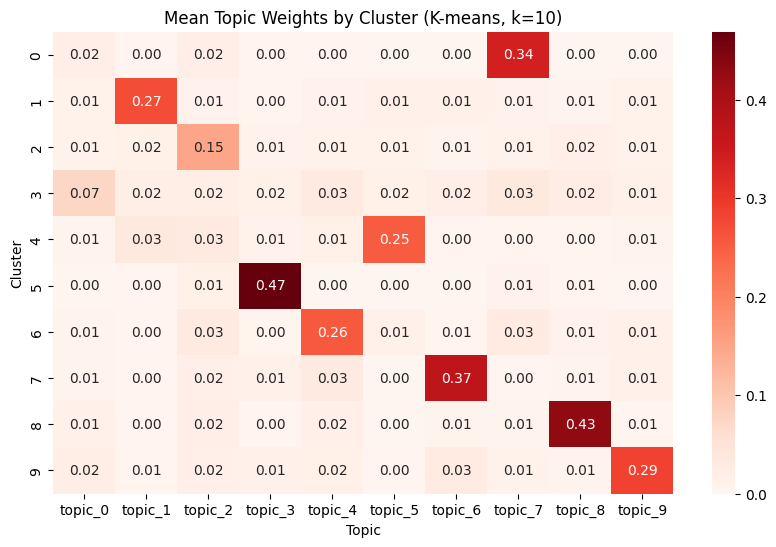


Cluster Characterization (based on dominant topics):
Cluster 0: Dominant topic_7 -> game, video, code, software, computer, program, sony, games, video game, fox
Cluster 1: Dominant topic_1 -> photograph, post, article, instagram, copyright, use photograph, new, posted, blog, photographer
Cluster 2: Dominant topic_2 -> defendant, plaintiff, book, court, published, ruling, novel, district, appealed district, court ruling
Cluster 3: Dominant topic_0 -> defendants, plaintiff, advertisement, parody, campaign, sculpture, hustler, defendants unauthorized, video, unauthorized
Cluster 4: Dominant topic_5 -> photographs, images, photos, gossip, celebrity, website, defendant, use photographs, celebrity gossip, plaintiff photographs
Cluster 5: Dominant topic_3 -> news, footage, lans, angeles, los, los angeles, service, video, news service, defendant
Cluster 6: Dominant topic_4 -> plaintiffs, works, university, factor, factors, court, students, district, district court, publishers
Cluster 7: Domin

In [ ]:
K = 10
cluster_labels = fair_use_findings["case_type_cluster"]

topic_cols = [f"topic_{i}" for i in range(K)]
cluster_interpretation = pd.DataFrame(nmf_results[K]["doc_topic"], columns=topic_cols)
cluster_interpretation["cluster"] = cluster_labels.values

cluster_profiles = cluster_interpretation.groupby("cluster").mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles, cmap="Reds", annot=True, fmt=".2f")
plt.title("Mean Topic Weights by Cluster (K-means, k=10)")
plt.xlabel("Topic")
plt.ylabel("Cluster")
plt.show()

print("\nCluster Characterization (based on dominant topics):")
terms = nmf_results[K]["terms"]

for cluster_id, row in cluster_profiles.iterrows():
    top_topic_idx = row.argmax()
    top_words_idx = nmf_results[K]["model"].components_[top_topic_idx].argsort()[::-1][:10]
    top_words = ", ".join(terms[top_words_idx])
    print(f"Cluster {cluster_id}: Dominant topic_{top_topic_idx} -> {top_words}")

We summarize fair-use rates by case type using determinate outcomes only. This confirms that case mix matters and motivates adjusting venue comparisons.

In [ ]:
cluster_outcomes = pd.crosstab(
    fair_use_findings["case_type_cluster"],
    fair_use_findings["outcome"]
)

determinate_cases = cluster_outcomes.get("FAIR_USE_FOUND", 0) + cluster_outcomes.get("FAIR_USE_NOT_FOUND", 0)
cluster_outcomes["fair_use_rate"] = cluster_outcomes.get("FAIR_USE_FOUND", 0) / determinate_cases
cluster_outcomes["total_determinate"] = determinate_cases

cluster_outcomes_sorted = cluster_outcomes.sort_values("fair_use_rate", ascending=False)

cluster_outcomes_sorted[["FAIR_USE_FOUND", "FAIR_USE_NOT_FOUND", "INDETERMINATE", "fair_use_rate", "total_determinate"]]

outcome,FAIR_USE_FOUND,FAIR_USE_NOT_FOUND,INDETERMINATE,fair_use_rate,total_determinate
case_type_cluster,,,,,
7,5,2,4,0.714286,7
1,12,6,5,0.666667,18
0,5,3,4,0.625000,8
9,11,7,2,0.611111,18
4,9,6,6,0.600000,15
3,26,25,12,0.509804,51
2,28,33,7,0.459016,61
5,1,4,0,0.200000,5
8,1,4,2,0.200000,5


We compute an expected fair-use probability for each case based on its case type (global case-type win rates). For each venue, we compare the actual fair-use rate to the expected rate implied by its case mix:

**Adjusted difference = Actual rate − Expected rate**

This adjusted difference is the main Q2 output.

,n_cases,actual_rate,expected_rate,adjusted_diff
court,,,,
United States District Court for the Central District of California,10,0.600,0.579,0.021
United States District Court for the Southern District of New York,38,0.526,0.516,0.010
United States Court of Appeals for the Second Circuit,31,0.419,0.471,-0.051
United States Court of Appeals for the Ninth Circuit,29,0.414,0.474,-0.060


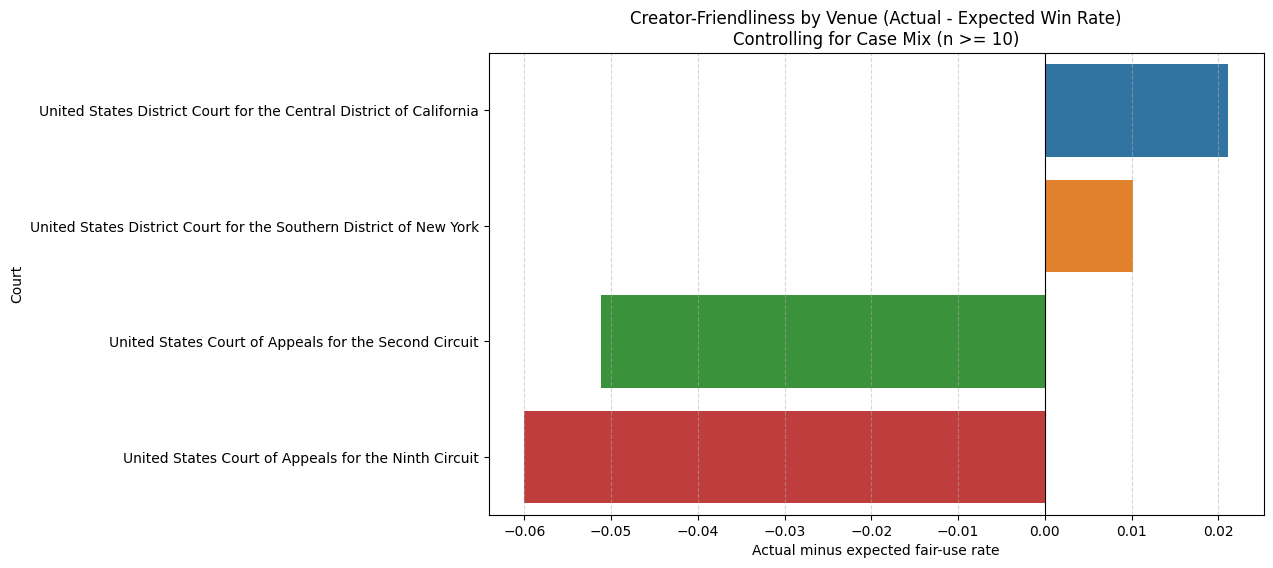

In [ ]:
df_det = fair_use_findings[
    fair_use_findings["outcome"].isin(["FAIR_USE_FOUND", "FAIR_USE_NOT_FOUND"])
].copy()

df_det["is_fair_use"] = (df_det["outcome"] == "FAIR_USE_FOUND").astype(int)

cluster_baselines = df_det.groupby("case_type_cluster")["is_fair_use"].mean()
df_det["expected_prob"] = df_det["case_type_cluster"].map(cluster_baselines)

venue_stats = df_det.groupby("court").agg(
    n_cases=("is_fair_use", "count"),
    actual_wins=("is_fair_use", "sum"),
    expected_wins=("expected_prob", "sum")
)

venue_stats["actual_rate"] = venue_stats["actual_wins"] / venue_stats["n_cases"]
venue_stats["expected_rate"] = venue_stats["expected_wins"] / venue_stats["n_cases"]
venue_stats["adjusted_diff"] = venue_stats["actual_rate"] - venue_stats["expected_rate"]

min_cases = 10
venue_analysis = venue_stats[venue_stats["n_cases"] >= min_cases].sort_values("adjusted_diff", ascending=False)

display(venue_analysis[["n_cases", "actual_rate", "expected_rate", "adjusted_diff"]].round(3))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=venue_analysis["adjusted_diff"],
    y=venue_analysis.index,
    hue=venue_analysis.index,
    legend=False
)
plt.axvline(0, color="black", linestyle="-", linewidth=0.8)
plt.title(f"Creator-Friendliness by Venue (Actual - Expected Win Rate)\nControlling for Case Mix (n >= {min_cases})")
plt.xlabel("Actual minus expected fair-use rate")
plt.ylabel("Court")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

Q2 is answered by the adjusted venue comparison (Actual − Expected). After controlling for case type, venue differences typically shrink relative to raw win-rate comparisons, indicating that **case mix explains a substantial portion** of apparent venue variation. Any remaining adjusted differences represent candidate venue effects beyond dispute type and are most interpretable in venues with enough determinate cases to support stable estimates.

From an integration standpoint, Q2 stays methodologically the same as M2, but benefits from M3 synergy because it reuses the same case-type backbone that supports Q1.

Q3: Categories Association Rules and Clustering

Q3 works well in isolation while we use similar TF-IDF methodology for clustering the categories otherwise there is little synergy in-terms of utilizing methods and outcomes from other questions

In [11]:
fair_use_findings['tags_list'] = fair_use_findings['tags'].str.split(';')
df_exploded = fair_use_findings.explode('tags_list')

df_exploded['tags_list'] = df_exploded['tags_list'].str.strip()

df_unique = df_exploded.drop_duplicates(subset=['case_number', 'tags_list'])
df_matrix = pd.crosstab(df_unique['case_number'], df_unique['tags_list'])
print("\nFinal Matrix Shape:", df_matrix.shape)
print(df_matrix.head())


Final Matrix Shape: (251, 59)
tags_list                                           Computer Program  \
case_number                                                            
108 F.3d 1119 (9th Cir. 1997), cert. denied 522...                 0   
109 F.3d 1394 (9th Cir. 1997)                                      0   
11 F. Supp. 2d 1179 (C.D. Cal. 1998)                               0   
126 F.3d 70 (2d Cir. 1997)                                         0   
132 F. Supp. 2d 229 (S.D.N.Y. 2001)                                0   

tags_list                                           Computer program  \
case_number                                                            
108 F.3d 1119 (9th Cir. 1997), cert. denied 522...                 0   
109 F.3d 1394 (9th Cir. 1997)                                      0   
11 F. Supp. 2d 1179 (C.D. Cal. 1998)                               0   
126 F.3d 70 (2d Cir. 1997)                                         0   
132 F. Supp. 2d 229 (S.D.N.Y. 20

Convert into an encoded format and apply Association Rules using confidence, support was found to not be as helpful in M2

In [12]:
frequent_itemsets = apriori(df_matrix, min_support=0.005, use_colnames=True)
frequent_itemsets.sort_values(by="support")

,support,itemsets
19,0.007968,"(Ninth Circuit, Photograph, Review/Commentary)"
28,0.007968,(Tenth Circuit)
272,0.007968,"(Second Circuit, Textual work, Painting/Drawin..."
275,0.007968,"(Second Circuit, Parody/Satire, Review/Comment..."
277,0.007968,"(Photograph, Review/Commentary, Sculpture)"
...,...,...
22,0.223108,(Photograph)
3,0.227092,(Education/Scholarship/Research)
9,0.239044,(Film/Audiovisual)
25,0.286853,(Second Circuit)


In [13]:
rules = association_rules(frequent_itemsets,
                          num_itemsets=frequent_itemsets.shape[0],
                          metric="confidence", min_threshold=0.4) #, metric="support", min_threshold=0.05
rules.sort_values(by=["support", "confidence"])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
42,"(Education/Scholarship/Research, Eleventh Circ...",(Internet/Digitization),0.019920,0.159363,0.007968,0.400000,2.510000,1.0,0.004794,1.401062,0.613821,0.046512,0.286256,0.225000
45,"(Education/Scholarship/Research, Eleventh Circ...",(Review/Commentary),0.019920,0.155378,0.007968,0.400000,2.574359,1.0,0.004873,1.407703,0.623984,0.047619,0.289623,0.225641
62,"(Music, Ninth Circuit)",(Education/Scholarship/Research),0.019920,0.227092,0.007968,0.400000,1.761404,1.0,0.003444,1.288181,0.441057,0.033333,0.223711,0.217544
98,"(Textual work, Eleventh Circuit)",(Internet/Digitization),0.019920,0.159363,0.007968,0.400000,2.510000,1.0,0.004794,1.401062,0.613821,0.046512,0.286256,0.225000
101,"(Textual work, Eleventh Circuit)",(Parody/Satire),0.019920,0.135458,0.007968,0.400000,2.952941,1.0,0.005270,1.440903,0.674797,0.054054,0.305991,0.229412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,(Internet/Digitization),(Photograph),0.159363,0.223108,0.063745,0.400000,1.792857,1.0,0.028190,1.294821,0.526066,0.200000,0.227692,0.342857
30,(Review/Commentary),(Second Circuit),0.155378,0.286853,0.075697,0.487179,1.698362,1.0,0.031126,1.390637,0.486842,0.206522,0.280905,0.375534
32,(Second Circuit),(Textual work),0.286853,0.330677,0.115538,0.402778,1.218039,1.0,0.020682,1.120726,0.251011,0.230159,0.107722,0.376088
8,(Textual work),(Education/Scholarship/Research),0.330677,0.227092,0.143426,0.433735,1.909956,1.0,0.068332,1.364923,0.711806,0.346154,0.267358,0.532657


In [14]:
rules_filtered = rules[(rules['confidence'] > 0.5) & (rules['lift'] >= 1.5)]
rules_filtered.sort_values(by=["confidence", "lift"], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
242,"(Film/Audiovisual, Ninth Circuit, Internet/Dig...",(Format shifting/Space Shifting),0.007968,0.007968,0.007968,1.000000,125.500000,1.0,0.007905,inf,1.000000,1.000000,1.000000,1.000000
248,(Format shifting/Space Shifting),"(Film/Audiovisual, Ninth Circuit, Internet/Dig...",0.007968,0.007968,0.007968,1.000000,125.500000,1.0,0.007905,inf,1.000000,1.000000,1.000000,1.000000
293,"(Photograph, Music)","(Film/Audiovisual, Ninth Circuit, Education/Sc...",0.007968,0.011952,0.007968,1.000000,83.666667,1.0,0.007873,inf,0.995984,0.666667,1.000000,0.833333
97,(Educational/Scholarship/Research),"(Internet/Digitization, Textual Work)",0.007968,0.015936,0.007968,1.000000,62.750000,1.0,0.007841,inf,0.991968,0.500000,1.000000,0.750000
105,(Format shifting/Space Shifting),"(Film/Audiovisual, Internet/Digitization)",0.007968,0.015936,0.007968,1.000000,62.750000,1.0,0.007841,inf,0.991968,0.500000,1.000000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,(Sixth Circuit),(Textual work),0.027888,0.330677,0.015936,0.571429,1.728055,1.0,0.006714,1.561753,0.433402,0.046512,0.359694,0.309811
65,"(Education/Scholarship/Research, Ninth Circuit)",(Textual work),0.027888,0.330677,0.015936,0.571429,1.728055,1.0,0.006714,1.561753,0.433402,0.046512,0.359694,0.309811
3,(Eleventh Circuit),(Education/Scholarship/Research),0.035857,0.227092,0.019920,0.555556,2.446394,1.0,0.011778,1.739044,0.613223,0.081967,0.424971,0.321637
13,(Eleventh Circuit),(Textual work),0.035857,0.330677,0.019920,0.555556,1.680054,1.0,0.008063,1.505976,0.419835,0.057471,0.335979,0.307898


For K means clustering, K was decieded as 5 after extensive investigation

In [15]:
fair_use_findings['full_text'] = (fair_use_findings['key_facts'].fillna('') + " " +
                                  fair_use_findings['issue'].fillna('') + " " +
                                  fair_use_findings['holding'].fillna(''))

my_stop_words = [
    'court', 'case', 'copyright', 'fair', 'use', 'plaintiff', 'defendant',
    'judge', 'district', 'appeal', 'circuit', 'infringement', 'holding',
    'fact', 'issue', 'summary', 'judgment', 'claimed', 'argued'
]

# 2. Vectorize with Custom Stop Words
#    We combine the standard English list with our custom legal list
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_stop_words = list(ENGLISH_STOP_WORDS) + my_stop_words

tfidf = TfidfVectorizer(max_features=3000,
                        stop_words=all_stop_words, # <--- The key change
                        ngram_range=(1,2))

text_matrix = tfidf.fit_transform(fair_use_findings['full_text'])

n_clusters_kmeans = 5

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
labels = kmeans.fit_predict(text_matrix)

fair_use_findings['cluster_labels'] = labels.astype(str)

print(f"--- Cases per Cluster (K={n_clusters_kmeans}) ---")
print(fair_use_findings['cluster_labels'].value_counts())

print("\n--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(n_clusters_kmeans):
    top_words = [terms[ind] for ind in order_centroids[i, :15]]
    print(f"Cluster {i}: {', '.join(top_words)}")

--- Cases per Cluster (K=5) ---
cluster_labels
1    90
4    83
2    31
3    28
0    19
Name: count, dtype: int64

--- Top Terms per Cluster ---
Cluster 0: advertisement, television, advertisements, booklet, defendants, tveyes, articles, poster, campaign, advertising, series, work, montage, comics, rocky
Cluster 1: plaintiffs, defendants, works, factor, film, copies, held, video, software, work, copying, did, news, song, market
Cluster 2: photograph, article, post, factor, work, photo, defendants, image, original, violent, violent hues, hues, purpose, blog, weighed
Cluster 3: photographs, images, photos, works, work, factor, sculpture, photograph, transformative, search, gossip, website, artwork, hustler, cmg
Cluster 4: defendants, work, factor, book, parody, song, market, works, favor, used, weighed, biography, material, finding, video
